In [1]:
%matplotlib inline

In [2]:
import altair as alt
import datetime
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import xarray as xr

In [3]:
# - See what dir we're in
os.getcwd()

'/opt/skipjack-bigeye-separation/python'

In [4]:
# - Set data path
dpath = '/opt/skipjack-bigeye-separation/data/'

# Load monthly 5 by 5 degree WCPFC catch and effort data

Variables loaded are:  
wf, begdate, enddate, timemocatch

In [6]:
ncfile = dpath + 'WCPFC/5by5deg/ByMonth/PurseSeine_0/WCPFC_purseseine_bysettype_monthly_5deg.nc'
wf = xr.open_dataset(ncfile) # WCPFC file
#wf

### Correct the time axis

In [7]:
# - Time goes from Jan 1967 - Dec 2017 --> 612 months
begdate = datetime.date(year = 1967, month = 1, day = 1)
enddate = datetime.date(year = 2017, month = 12, day = 1)
timemocatch = pd.date_range(begdate, enddate, freq='MS')
#np.array(timemocatch)

In [8]:
wf['time'] = timemocatch
#wf

# Load monthly ENSO time series

Variables loaded/calculated are:  
oni, onien, oniln, onitime

In [9]:
# - Load ONI 
dfoni = pd.read_csv(dpath+'ENSOindices/oni/oniindex1950_2018.txt',names=['Date','ONI']);
#dfoni.head(2)

# - Month fractions corresp to jan, feb, mar, etc. in the ONI txt file
monthfracs = [0,0.0834,0.1666,0.25,0.3334,0.4166,0.5,0.5834,0.6666,0.75,0.8334,0.9166];

# - Get ONI ts over desired timeframe
onibegmoidx = dfoni.index[dfoni['Date'] == (begdate.year + monthfracs[begdate.month-1])][0]
oniendmoidx = dfoni.index[dfoni['Date'] == (enddate.year + monthfracs[enddate.month-1])][0]
oni = dfoni['ONI'].iloc[onibegmoidx:(oniendmoidx+1)].values
onitime = pd.date_range(begdate, enddate, freq='MS') # should be 612 months long
#type(oni)

In [10]:
# - Create EN/LN month classifications
onien = [0]*len(oni) # 1 = el nino month
oniln = [0]*len(oni) # 1 = la nina month

# - Classify El Nino months
cmcounter = 0; # consecutive months counter
for imonth in range(len(oni)):
    if oni[imonth]>=0.5:
        cmcounter=cmcounter+1;
    elif oni[imonth]<0.5:
        cmcounter=0;
    if cmcounter>=5:
        onien[imonth-cmcounter:imonth]=[1]*cmcounter;

# - Classify La Nina months
cmcounter = 0; # consecutive months counter
for imonth in range(len(oni)):
    if oni[imonth]<=-0.5:
        cmcounter=cmcounter+1;
    elif oni[imonth]>-0.5:
        cmcounter=0;
    if cmcounter>=5:
        oniln[imonth-cmcounter:imonth]=[1]*cmcounter;

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


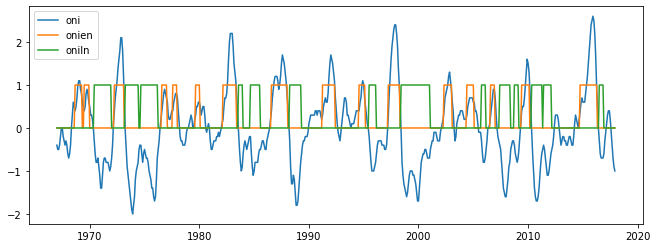

In [12]:
plotensoidx=1
if plotensoidx==1:
    fig = plt.figure(figsize=(11,4))
    plt.plot(onitime,oni)
    plt.plot(onitime,onien)
    plt.plot(onitime,oniln)
    plt.legend(["oni","onien","oniln"])

# Calculate WCPFC total catch, CPUE, effot, bet:skj catch ratio, and bet:skj CPUE ratio

Variables calced are:  
skj_c_tot, bet_c_tot, sets_tot, skj_cp_tot, bet_cp_tot, bettoskj_cp_tot,  
bettoskj_totc_tot, bettoskj_totcp_tot

In [13]:
# - The following are 3-D (time, lon, lat):
skj_c_tot = wf.skj_c_una + wf.skj_c_log + wf.skj_c_dfad + wf.skj_c_afad + wf.skj_c_oth
bet_c_tot = wf.bet_c_una + wf.bet_c_log + wf.bet_c_dfad + wf.bet_c_afad + wf.bet_c_oth
sets_c_tot = wf.sets_una + wf.sets_log + wf.sets_dfad + wf.sets_afad + wf.sets_oth
skj_cp_tot = skj_c_tot/sets_c_tot
bet_cp_tot = bet_c_tot/sets_c_tot
bettoskj_cp_tot = bet_cp_tot/skj_cp_tot

# - The following are 2-D (lon, lat):
bettoskj_totc_tot = bet_c_tot.sum('time')/skj_c_tot.sum('time')
bettoskj_totcp_tot = bet_cp_tot.sum('time')/skj_cp_tot.sum('time')

In [14]:
# - Name the dataarrays for later merging into datasets
skj_c_tot.name = 'skj_c_tot'
bet_c_tot.name = 'bet_c_tot'
skj_cp_tot.name = 'skj_cp_tot'
bet_cp_tot.name = 'bet_cp_tot'
bettoskj_cp_tot.name = 'bettoskj_cp_tot'

In [15]:
# - Test plot
#bettoskj_cp_tot.isel(lat=10,lon=10).plot()

# Calculate WCPFC total catch, CPUE, effot, bet:skj catch ratio, bet:skj CPUE ratio monthly anoms/climatology

Variables calced are:  
skj_c_tot_clim, bet_c_tot_clim, skj_cp_tot_clim, bet_cp_tot_clim, bettoskj_cp_tot_clim,  
skj_c_tot_anom, bet_c_tot_anom, skj_cp_tot_anom, bet_cp_tot_anom, bettoskj_cp_tot_anom

In [16]:
# - The following are 3-D (time, lon, lat):
skj_c_tot_clim = skj_c_tot.groupby('time.month').mean('time')
bet_c_tot_clim = bet_c_tot.groupby('time.month').mean('time')
skj_cp_tot_clim = skj_cp_tot.groupby('time.month').mean('time')
bet_cp_tot_clim = bet_cp_tot.groupby('time.month').mean('time')
bettoskj_cp_tot_clim = bettoskj_cp_tot.groupby('time.month').mean('time')
skj_c_tot_anom = skj_c_tot.groupby('time.month') - skj_c_tot_clim
bet_c_tot_anom = bet_c_tot.groupby('time.month') - bet_c_tot_clim
skj_cp_tot_anom = skj_cp_tot.groupby('time.month') - skj_cp_tot_clim
bet_cp_tot_anom = bet_cp_tot.groupby('time.month') - bet_cp_tot_clim
bettoskj_cp_tot_anom = bettoskj_cp_tot.groupby('time.month') - bettoskj_cp_tot_clim

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [17]:
# - Name the dataarrays for later merging into datasets
skj_c_tot_clim.name = 'skj_c_tot_clim'
bet_c_tot_clim.name = 'bet_c_tot_clim'
skj_cp_tot_clim.name = 'skj_cp_tot_clim'
bet_cp_tot_clim.name = 'bet_cp_tot_clim'
bettoskj_cp_tot_clim.name = 'bettoskj_cp_tot_clim'
skj_c_tot_anom.name = 'skj_c_tot_anom'
bet_c_tot_anom.name = 'bet_c_tot_anom'
skj_cp_tot_anom.name = 'skj_cp_tot_anom'
bet_cp_tot_anom.name = 'bet_cp_tot_anom'
bettoskj_cp_tot_anom.name = 'bettoskj_cp_tot_anom'

In [18]:
# - Test plot
#skj_cpp_tot_clim.isel(lat=10,lon=10).plot()

# Calculate mean and ENSO composites of total catch, CPUE, effort, bet:skj CPUE

Variables calced are:  
skj_c_tot_clim, bet_c_tot_clim, skj_cp_tot_clim, bet_cp_tot_clim, bettoskj_cp_tot_clim,  
skj_c_tot_anom, bet_c_tot_anom, skj_cp_tot_anom, bet_cp_tot_anom, bettoskj_cp_tot_anom

In [233]:
# https://github.com/pydata/xarray/issues/557
test = skj_c_tot.where(ds_tot['onien']==1)

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


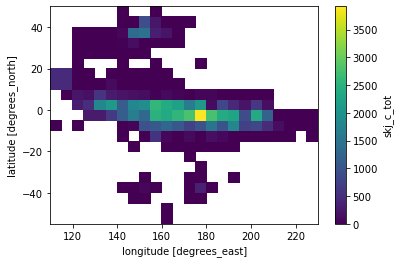

In [234]:
test.mean('time').plot.pcolormesh()

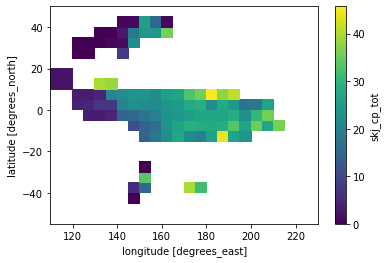

In [218]:
skj_cp_tot_mean.plot.pcolormesh()

In [217]:
skj_c_tot_mean = skj_c_tot.mean('time')
bet_c_tot_mean = bet_c_tot.mean('time')
skj_cp_tot_mean = skj_cp_tot.mean('time')
bet_cp_tot_mean = bet_cp_tot.mean('time')
skj_c_tot_en = skj_c_tot.where(onien==1)

# Question 0b from 9/19/19 in written lab notebook

In [19]:
skj_c_tot_clim.name = 'skj_c_tot_clim'
bet_c_tot_clim.name = 'bet_c_tot_clim'
skj_cp_tot_clim.name = 'skj_cp_tot_clim'
bet_cp_tot_clim.name = 'bet_cp_tot_clim'
bettoskj_cp_tot_clim.name = 'bettoskj_cp_tot_clim'

In [21]:
ds_tot = xr.merge([skj_c_tot, bet_c_tot, skj_cp_tot, bet_cp_tot, bettoskj_cp_tot])

In [22]:
ds_tot['oni'] = (('time'), oni)

In [230]:
ds_tot['onien'] = (('time'), onien)

In [231]:
ds_tot['oniln'] = (('time'), oniln)

In [23]:
ds_tot['season'] = ds_tot['time.season']

In [232]:
ds_tot

<xarray.Dataset>
Dimensions:          (lat: 21, lon: 24, time: 612)
Coordinates:
  * lon              (lon) float32 112.5 117.5 122.5 127.5 ... 217.5 222.5 227.5
  * lat              (lat) float32 -52.5 -47.5 -42.5 -37.5 ... 37.5 42.5 47.5
  * time             (time) datetime64[ns] 1967-01-01 1967-02-01 ... 2017-12-01
Data variables:
    skj_c_tot        (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    bet_c_tot        (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    skj_cp_tot       (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    bet_cp_tot       (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    bettoskj_cp_tot  (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    oni              (time) float64 -0.4 -0.5 -0.5 -0.4 ... -0.4 -0.7 -0.9 -1.0
    season           (time) <U3 'DJF' 'DJF' 'MAM' 'MAM' ... 'SON' 'SON' 'DJF'
    onien            (time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    oniln            (time) int64 0 

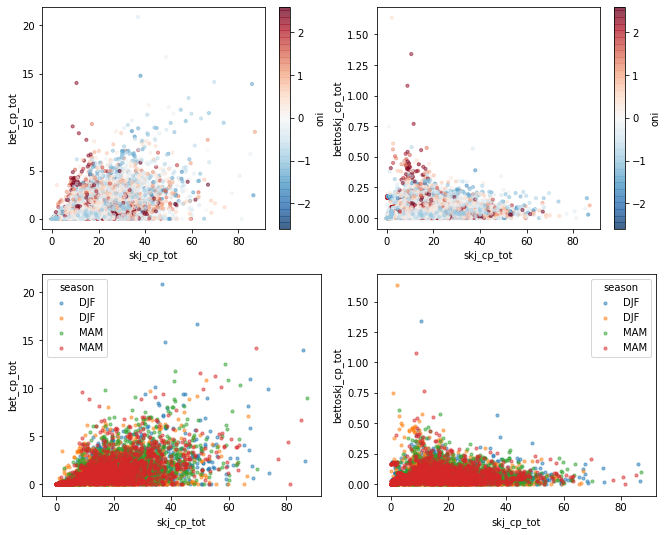

In [26]:
# - This is good but the season labeling gets weird, so don't use this and use pd df + matplotlib scatterplots instead
#fig,axes = plt.subplots(2, 2, figsize = (11, 9))
#ds_tot.plot.scatter(ax=axes[0][0], x='skj_cp_tot', y='bet_cp_tot', s=10, alpha=0.5, hue='oni');
#ds_tot.plot.scatter(ax=axes[0][1], x='skj_cp_tot', y='bettoskj_cp_tot', s=10, alpha=0.5, hue='oni');
#ds_tot.plot.scatter(ax=axes[1][0], x='skj_cp_tot', y='bet_cp_tot', s=10, alpha=0.5, hue='season');
#ds_tot.plot.scatter(ax=axes[1][1], x='skj_cp_tot', y='bettoskj_cp_tot', s=10, alpha=0.5, hue='season');

In [ ]:
# - Since the season gets labeled weird in the above scatterplot code,
# convert everything to dataframe
df_tot = ds_tot.to_dataframe()

In [61]:
df_tot.reset_index(inplace=True)

In [63]:
df_tot.shape

(308448, 10)

In [64]:
df_tot.loc[df_tot['season'] == 'DJF', 'seas_num'] = 1
df_tot.loc[df_tot['season'] == 'MAM', 'seas_num'] = 2
df_tot.loc[df_tot['season'] == 'JJA', 'seas_num'] = 3
df_tot.loc[df_tot['season'] == 'SON', 'seas_num'] = 4

In [69]:
df_tot['seas_num'] = df_tot['seas_num'].astype(int)

In [88]:
season_colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0), (255, 165, 0)]  # B -> G -> R --> Y
seasons_cm = LinearSegmentedColormap.from_list('seasons_cmap', colors, N=4)

In [89]:
df_tot.head(2)

lat    lon       time  skj_c_tot  bet_c_tot  skj_cp_tot  bet_cp_tot  \
0 -52.5  112.5 1967-01-01        NaN        NaN         NaN         NaN   
1 -52.5  112.5 1967-02-01        NaN        NaN         NaN         NaN   

   bettoskj_cp_tot  oni season  seas_num  
0              NaN -0.4    DJF         1  
1              NaN -0.5    DJF         1

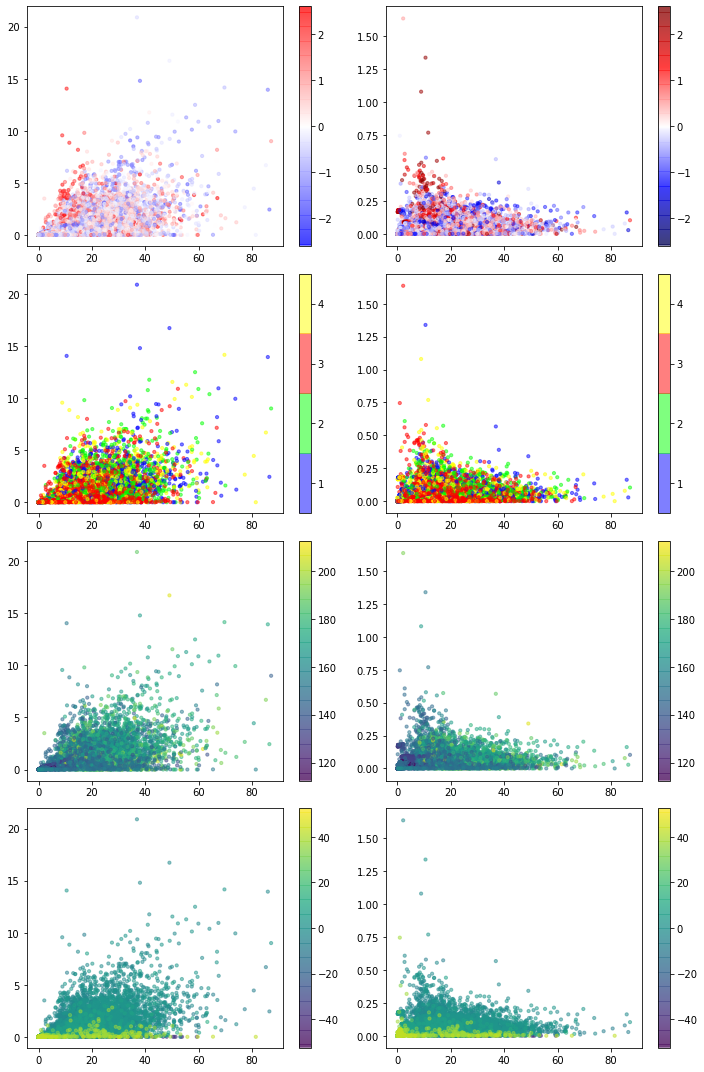

In [95]:
fig,axes = plt.subplots(nrows=4, ncols=2, figsize = (10, 15))
# - Color by oni
sc = axes[0][0].scatter(df_tot['skj_cp_tot'],df_tot['bet_cp_tot'],
                 c=df_tot['oni'],vmin=-abs(df_tot['oni']).max(),vmax=abs(df_tot['oni']).max(),
                 s=10,alpha=0.5,cmap=cm.bwr); plt.colorbar(sc, ax=axes[0][0]);
sc = axes[0][1].scatter(df_tot['skj_cp_tot'],df_tot['bettoskj_cp_tot'],
                 c=df_tot['oni'],vmin=-abs(df_tot['oni']).max(),vmax=abs(df_tot['oni']).max(),
                 s=10,alpha=0.5,cmap=cm.seismic); plt.colorbar(sc, ax=axes[0][1]);
# - Color by season
sc = axes[1][0].scatter(df_tot['skj_cp_tot'],df_tot['bet_cp_tot'],
                 c=df_tot['seas_num'],vmin=0.5,vmax=4.5,
                 s=10,alpha=0.5,cmap=seasons_cm); plt.colorbar(sc, ax=axes[1][0], ticks=range(1,5));
sc = axes[1][1].scatter(df_tot['skj_cp_tot'],df_tot['bettoskj_cp_tot'],
                 c=df_tot['seas_num'],vmin=0.5,vmax=4.5,
                 s=10,alpha=0.5,cmap=seasons_cm); plt.colorbar(sc, ax=axes[1][1], ticks=range(1,5));
# - Color by longitude
sc = axes[2][0].scatter(df_tot['skj_cp_tot'],df_tot['bet_cp_tot'],
                 c=df_tot['lon'],
                 s=10,alpha=0.5,cmap=cm.viridis); plt.colorbar(sc, ax=axes[2][0]);
sc = axes[2][1].scatter(df_tot['skj_cp_tot'],df_tot['bettoskj_cp_tot'],
                 c=df_tot['lon'],
                 s=10,alpha=0.5,cmap=cm.viridis); plt.colorbar(sc, ax=axes[2][1]);
# - Color by latitude
sc = axes[3][0].scatter(df_tot['skj_cp_tot'],df_tot['bet_cp_tot'],
                 c=df_tot['lat'],vmin=-abs(df_tot['lat']).max(),vmax=abs(df_tot['lat']).max(),
                 s=10,alpha=0.5,cmap=cm.viridis); plt.colorbar(sc, ax=axes[3][0]);
sc = axes[3][1].scatter(df_tot['skj_cp_tot'],df_tot['bettoskj_cp_tot'],
                 c=df_tot['lat'],vmin=-abs(df_tot['lat']).max(),vmax=abs(df_tot['lat']).max(),
                 s=10,alpha=0.5,cmap=cm.viridis); plt.colorbar(sc, ax=axes[3][1]);
fig.tight_layout()

# Question 0b from 9/19/19 in written lab notebook

In [146]:
df_tot_nn = df_tot.dropna(subset=['skj_cp_tot','bet_cp_tot','bettoskj_cp_tot'], how='any')

In [157]:
df_tot_nn_small = df_tot_nn.iloc[0:1000]

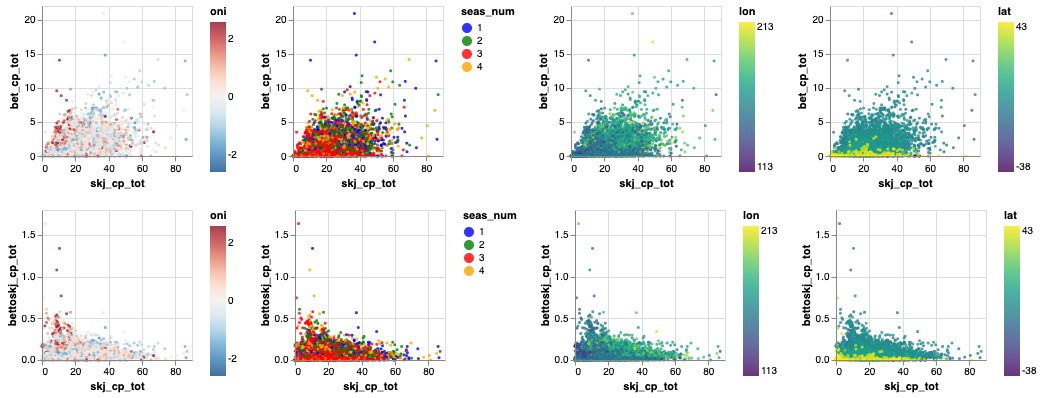

In [204]:
# https://stackoverflow.com/questions/56428206/altair-linked-map-with-scatter-plot
# https://github.com/altair-viz/altair/issues/588 - see responses by iliatimofeev
# https://altair-viz.github.io/user_guide/faq.html#maxrowserror-how-can-i-plot-large-datasets
alt.data_transformers.disable_max_rows()

interval = alt.selection_interval()

# - Define scatterplots
bvss_sc = alt.Chart(df_tot_nn).mark_circle(size=8,opacity=0.8).encode(
    x='skj_cp_tot:Q',
    y='bet_cp_tot:Q'
).properties(
    selection=interval,
    width=200,
    height=200
)
b2svss_sc = alt.Chart(df_tot_nn).mark_circle(size=8,opacity=0.8).encode(
    x='skj_cp_tot:Q',
    y='bettoskj_cp_tot:Q'
).properties(
    selection=interval,
    width=200,
    height=200
)

# - Colors to color scatterplot points by
oni_color = alt.Color('oni:Q', scale=alt.Scale(scheme='redblue', domain=[-abs(df_tot_nn['oni']).max(),abs(df_tot_nn['oni']).max()]), sort='descending')
seas_color = alt.Color('seas_num:N', scale=alt.Scale(domain=[1, 2, 3, 4], range=['blue','green','red','orange'])) 
lon_color = alt.Color('lon:Q', scale=alt.Scale(scheme='viridis'))
lat_color = alt.Color('lat:Q', scale=alt.Scale(scheme='viridis'))

# - Create plots, format 1
#(bvss_sc.encode(color=alt.condition(interval, oni_color, alt.value('lightgray'))
#              ) | b2svss_sc.encode(color=alt.condition(interval, oni_color, alt.value('lightgray')))
#) & (bvss_sc.encode(color=alt.condition(interval, seas_color, alt.value('lightgray'))
#              ) | b2svss_sc.encode(color=alt.condition(interval, seas_color, alt.value('lightgray')))
#) & (bvss_sc.encode(color=alt.condition(interval, lon_color, alt.value('lightgray'))
#              ) | b2svss_sc.encode(color=alt.condition(interval, lon_color, alt.value('lightgray')))
#) & (bvss_sc.encode(color=alt.condition(interval, lat_color, alt.value('lightgray'))
#              ) | b2svss_sc.encode(color=alt.condition(interval, lat_color, alt.value('lightgray'))))

# - Create plots, format 2
(bvss_sc.encode(color=alt.condition(interval, oni_color, alt.value('lightgray'))
    ) | bvss_sc.encode(color=alt.condition(interval, seas_color, alt.value('lightgray'))
        ) | bvss_sc.encode(color=alt.condition(interval, lon_color, alt.value('lightgray'))
            ) | bvss_sc.encode(color=alt.condition(interval, lat_color, alt.value('lightgray')))
) & (b2svss_sc.encode(color=alt.condition(interval, oni_color, alt.value('lightgray'))
    ) | b2svss_sc.encode(color=alt.condition(interval, seas_color, alt.value('lightgray'))
        ) | b2svss_sc.encode(color=alt.condition(interval, lon_color, alt.value('lightgray'))
            ) | b2svss_sc.encode(color=alt.condition(interval, lat_color, alt.value('lightgray')))) 

In [ ]:
interval = alt.selection_interval()
med_inc_color = alt.Color('med_inc:Q', scale=alt.Scale(scheme='viridis'))

# - Scatterplots
base = alt.Chart(cbgs_join_df).mark_circle(opacity=0.8,size=8).encode(
    color=alt.condition(interval, med_inc_color, alt.value('lightgray'), legend=alt.Legend(orient='left', title='%white')),
    tooltip='med_inc'
    ).properties(
        selection=interval,
        width=300
    )

scatter = base.encode(alt.X('lon', scale=alt.Scale(domain=[-123.5, -120])), y=alt.Y('lat', scale=alt.Scale(domain=[46.9, 49]))) | base.encode(x='avg_dist', y='avg_toll_wohov')

# - Boxplot
boxplot = alt.Chart(cbgs_join_df).mark_boxplot(extent='min-max').encode(
    y=alt.Y('med_inc', scale=alt.Scale(domain=[0, 250000]))
).transform_filter(
    interval
)

# - Background map
cbgs_join_json = alt.InlineData(values = cbgs_join.to_json(), #geopandas to geojson string
                       # root object type is "FeatureCollection" but we need its features
                       format = alt.DataFormat(property='features',type='json')) 
background = alt.Chart(cbgs_join_json).mark_geoshape(
    #color='med_inc:Q',
    fill='lightgray',
    stroke='white'
    ).properties(
        width=500,
        height=300
    ).project('mercator')

# - Points at centroids of block groups
points = alt.Chart(cbgs_join_df).mark_circle(size=6).encode(
    longitude='lon',
    latitude='lat',
    #tooltip=['name', 'city', 'state'],
    color=alt.condition(interval, med_inc_color, alt.value('lightgray'))
    )

# - Text
table = alt.Chart(cbgs_join_df).mark_text().encode(
    text='median(med_inc)'
).transform_filter(
    interval
).properties(
    title='Median median income'
)

scatter & (boxplot | table | (background+points))

In [ ]:
import netCDF4 as nc
import numpy as np
import scipy as sp
from reverse_colormap import reverse_colormap
import cmocean

# Calculate mean and ENSO composites of total catch, CPUE, effort bet:skj catch and CPUE

In [ ]:
skj_c_tot_mean = np.mean(skj_c_tot,axis=0)
skj_c_tot_en = np.mean(np.squeeze(skj_c_tot[np.where(onien),:,:]),axis=0)
skj_c_tot_ln = np.mean(np.squeeze(skj_c_tot[np.where(oniln),:,:]),axis=0)

bet_c_tot_mean = np.mean(bet_c_tot,axis=0)
bet_c_tot_en = np.mean(np.squeeze(bet_c_tot[np.where(onien),:,:]),axis=0)
bet_c_tot_ln = np.mean(np.squeeze(bet_c_tot[np.where(oniln),:,:]),axis=0)

skj_cp_tot_mean = np.mean(skj_cp_tot,axis=0)
skj_cp_tot_en = np.mean(np.squeeze(skj_cp_tot[np.where(onien),:,:]),axis=0)
skj_cp_tot_ln = np.mean(np.squeeze(skj_cp_tot[np.where(oniln),:,:]),axis=0)

bet_cp_tot_mean = np.mean(bet_cp_tot,axis=0)
bet_cp_tot_en = np.mean(np.squeeze(bet_cp_tot[np.where(onien),:,:]),axis=0)
bet_cp_tot_ln = np.mean(np.squeeze(bet_cp_tot[np.where(oniln),:,:]),axis=0)

sets_tot_mean = np.mean(sets_tot,axis=0)
sets_tot_en = np.mean(np.squeeze(sets_tot[np.where(onien),:,:]),axis=0)
sets_tot_ln = np.mean(np.squeeze(sets_tot[np.where(oniln),:,:]),axis=0)

bettoskj_c_tot_mean = np.mean(bettoskj_c_tot,axis=0)
bettoskj_c_tot_en = np.mean(np.squeeze(bettoskj_c_tot[np.where(onien),:,:]),axis=0)
bettoskj_c_tot_ln = np.mean(np.squeeze(bettoskj_c_tot[np.where(oniln),:,:]),axis=0)